# mom6_bathy Notebook Gallery
## Spherical grid with custom bathymetry and ridges

In this notebook, we create a spherical grid with uniform resolution. We then implement a user-defined, custom bathymetry including ridges.

## 1. Import Modules

In [1]:
%%capture
import numpy as np
from mom6_bathy.mom6grid import mom6grid
from mom6_bathy.mom6bathy import mom6bathy

## 2. Create a horizontal MOM6 grid

Spherical grid. x coordinates interval= [0, 360] degrees. y coordinates interval = [-80,+80] degrees

In [2]:
# Instantiate a MOM6 grid instance
grd = mom6grid(
        nx         = 180,         # Number of grid points in x direction
        ny         = 80,          # Number of grid points in y direction
        config     = "spherical", # Grid configuration. Valid values: 'cartesian', 'mercator', 'spherical'
        axis_units = "degrees",   # Grid axis units. Valid values: 'degrees', 'm', 'km'
        lenx       = 360.0,       # grid length in x direction, e.g., 360.0 (degrees)
        leny       = 160,         # grid length in y direction
        cyclic_x   = "True",      # reentrant, spherical domain
        ystart     = -80          # start/end 10 degrees above/below poles to avoid singularity 
)

Updating supergrid...


## 3. Configure the bathymetry

In [3]:
# Instantiate a mom6bathy object associated with the horizontal grid object (grd).
bathy = mom6bathy(grd, min_depth=10.0)

### *Define a custom bathymetry*

In [4]:
# Define a sinusoidal depth array:
i = grd.tlat.nx.data                # array of x-indices
j = grd.tlat.ny.data[:,np.newaxis]  # array of y-indices 
custom_depth = 400.0 + 80.0 * np.sin(i*np.pi/6.) * np.cos(j*np.pi/6.)
bathy.set_depth_arr(custom_depth)

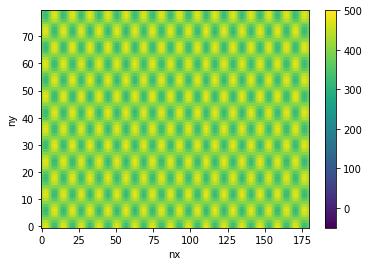

In [5]:
bathy.depth.plot(vmin=-50, vmax=500)

### *Apply ridges*

In [6]:
# apply a submerged ridge ( height of 300 m):
bathy.apply_ridge(height=400.0, width=4.0, lon=100, ilat=(10,70) )

In [7]:
# apply a ridge reaching above MSL ( height of 600 m):
bathy.apply_ridge(height=600.0, width=6.0, lon=240, ilat=(10,70) )

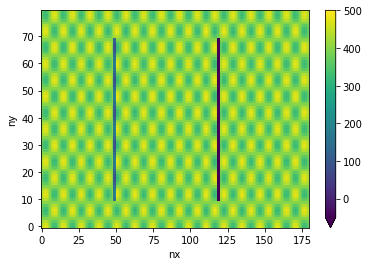

In [8]:
bathy.depth.plot(vmin=-50, vmax=500)

### *Plot the ocean mask:*

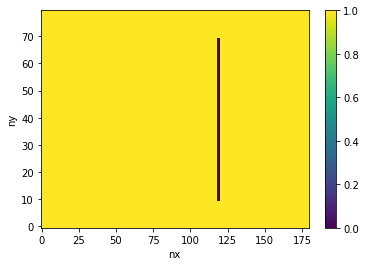

In [9]:
bathy.tmask.plot()

## 4. Save the grid and bathymetry files

In [10]:
# supergrid file:
grd.to_netcdf(supergrid_path="./ocean_hgrid_spcb.nc")

# ocean_topog:
bathy.to_topog("./ocean_topog_spcb.nc")

# SCRIP file:
bathy.to_SCRIP("./SCRIP_spcb.nc")

*To create an ESMF mesh file:*

`$ ESMF_Scrip2Unstruct SCRIP_spcb.nc ESMFmesh_spcb.nc 0`

## Further Steps

### *Initial Conditions*

For this simple model, we choose to adopt an idealized initial conditions (temperature and salinity) predefined in MOM6 internally. To do so, we set the following MOM6 runtime parameters in MOM_input:
```
TS_CONFIG = "fit"     ! find the temperatures that are consistent with the layer densities and salinity S_REF.
T_REF = -1.9          ! A reference temperature used in initialization.
FIT_SALINITY = True   ! If true, accept the prescribed temperature and fit the salinity
```

### *Configure MOM6*

We run the `print_MOM6_runtime_params` method of `bathy` to print out the grid and bathymetry related MOM6 runtime parameters to be set in MOM_input or MOM_override:

In [11]:
bathy.print_MOM6_runtime_params()

TRIPOLAR_N = False
NIGLOBAL = 180
NJGLOBAL = 80
GRID_CONFIG = mosaic
TOPO_CONFIG = file
MAXIMUM_DEPTH = 480.0
MINIMUM_DEPTH = 10.0
REENTRANT_X = True
GRID_FILE = ???
TOPO_FILE = ???
